In [ ]:
!pip3 install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

In [3]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])
# 받을 데이터를 어떻게 전처리 할 것인지에 대한 설정들 한번에 선언. 각각 28 x 28 크기로, tensor로 변환하며, 각 사진을 (평균), (표준편차) 로 정규화 한다는 뜻이다.
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# MNIST 데이터셋을 받아온다. transform=transtorm을 이용하여 사용자가 지정한 전처리 방식으로 데이터를 받아올 것이다.

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)
# torch.utils.data.DataLoader로 데이터를 불러오고, shuffle 패러미터를 True로 해줌으로써, 데이터를 섞어준다.

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy() 
  # tensor를 복사한다. 그러나 detech() 속성을 줬기 때문에, 원본이 변한다고 image가 변하진 않는다. 그러나 detech()로 생성한 tensor가 변한다면 원본 tensor도 변한다.
  image = image.transpose(1, 2, 0)
  # 3차원 행렬의 모양을 변경한다. i x j x k(z * x * y)의 행렬이었다면 i = 0, j = 1, k = 2로 해서 i, j, k의 위치를 바꿔준다.
  # 원래 행렬의 2차원 요소가 3차원으로 간다. (x -> z)
  # 원래 행렬의 3차원 요소가 1차원으로 간다. (z -> y)
  # 원래 행렬의 1차원 요소가 2차원으로 간다. (y -> x)
  # 원래가 z * x * y 모양이었다면, 변환 후는 x * y * z 모양일 것이다.
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  # image의 값을 변경해 준 후, 그 값을 최소 0, 최대 1인 값으로 제한한다. (흑백의 경계를 비교적 명확히 표현해주기 위함)
  return image

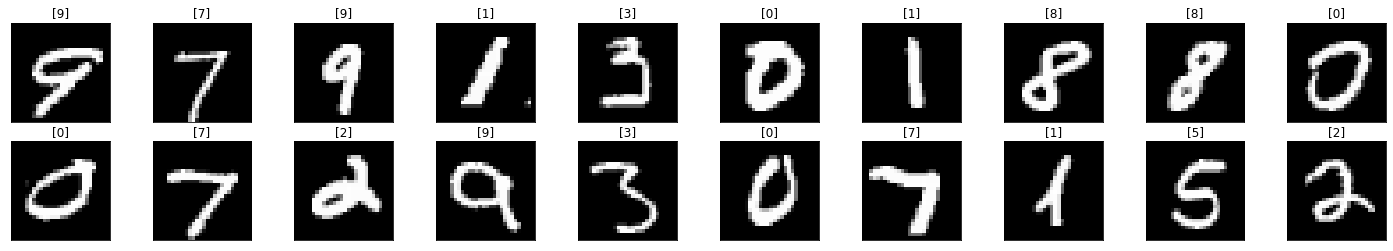

In [21]:
dataiter = iter(training_loader) # 트레이닝 데이터셋의 iterator 생성
images, labels = dataiter.next() # images = 각 이미지의 명암값, labels = 각 이미지의 정답
fig = plt.figure(figsize=(25, 4)) # 이미지 출력할 칸 25 x 4개만큼 생성

for idx in np.arange(20): # 20번 반복
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # 2 x 10 칸의 subplot 생성
  plt.imshow(im_convert(images[idx])) # idx번의 이미지 흑백으로 출력
  ax.set_title([labels[idx].item()]) # idx번의 label 제목으로 출력

In [9]:
class Classifier(nn.Module): # 여러 활성함수 등을 이용하기 위해 nn.Module을 상속받는다.
    def __init__(self, D_in, H1, H2, D_out): # 각각 입력 차원, 은닉층의 차원 1, 2, 출력 차원이다.
        super().__init__() # nn.Module 생성자 선언
        self.linear1 = nn.Linear(D_in, H1) # 입력 차원 -> 1번 은닉층 차원으로 첫 번쨰 선형변환(Linear Regression) 실행
        self.linear2 = nn.Linear(H1, H2) # 1번 은닉층 차원 -> 2번 은닉층 차원으로 두 번째 선형변환 실행
        self.linear3 = nn.Linear(H2, D_out) # 2번 은닉층 차원 -> 출력 차원으로 세 번째 선형변환 실행
    def forward(self, x):
        x = F.relu(self.linear1(x)) 
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # functional 라이브러리의 내장함수 relu 활성함수를 이용하여 세 번에 걸쳐 다음 층으로 진행한다.
        return x

In [10]:
model = Classifier(784, 125, 65, 10)
model
# model의 출력결과로 봤을 때, 데이터의 차원이 효과적으로 줄어들고 있는것을 확인할 수 있다.

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss를 계산하기 위한 함수. 다중분류를 하기 위해 사용한다.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # SGD보다 방향성과 스템 사이즈 등에서 효율적인 Adam optimizer를 사용한다.

In [13]:
epochs = 15 # 15번 반복
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = [] # 진행 경과에 따른 loss나 정답율을 저장받을 배열들 선언

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0 # 정답, 오답 초기화
  
  for inputs, labels in training_loader: # 트레이닝 데이터셋에 대하여 훈련 시작
    inputs = inputs.view(inputs.shape[0], -1) 
    # tensor.view()에 -1을 넣으면 나오는 결과를 이용하여 inputs tensor를 (inputs.shaoe[0] x 1) 꼴로 변환한다.
    outputs = model(inputs)
    # Linear Regression 실행
    loss = criterion(outputs, labels)
    # CrossEntropyLoss() 구하기
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # 변화율 초기화, 역전파, 가중치 갱신(Linear_Regression.ipynb와 동일)
    
    _, preds = torch.max(outputs, 1) # 출력은 0 ~ 9 의 분류에 대한 값으로 나타난다. 그러므로, 가장 정답에 가까운(수가 높은) 값을 가져오기 위해 max를 사용한다.
    running_loss += loss.item() # 손실율 합산
    running_corrects += torch.sum(preds == labels.data) # 정답시 running_corrects에 +1, 오답시 +0

  else: # for/else문, for문이 정상적으로 모두 실행 된다면 이 구문이 실행된다. (정상적으로 training이 완료되었을때 실행 된다.)
    with torch.no_grad(): # 지금부터 나올 블록은 변화율을 추적하지 않겠다는 뜻이다. 평가를 하기 위한 부분이므로 이 부분은 변화율을 추적할 필요가 없다.
      for val_inputs, val_labels in validation_loader: # 평가 데이터에 대해 모델 평가 시작
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data) # 기본적인 로직은 training 할 때 와 같다.
      
    epoch_loss = running_loss/len(training_loader) # 학습 한번에 대한 오답률 저장
    epoch_acc = running_corrects.float()/ len(training_loader) # 학습 한번에 대한 정답률 저장
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc) # 배열에 추가
    
    val_epoch_loss = val_running_loss/len(validation_loader) # 평가 한번에 대한 오답률 저장
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader) #평가 한번에 대한 정답률 저장
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc) # 배열에 추가
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item())) # 출력

epoch : 1
training loss: 0.9478, acc 78.1033 
validation loss: 0.4188, validation acc 88.9200 
epoch : 2
training loss: 0.3761, acc 89.4933 
validation loss: 0.3179, validation acc 91.1200 
epoch : 3
training loss: 0.3147, acc 90.9750 
validation loss: 0.2822, validation acc 92.0100 
epoch : 4
training loss: 0.2829, acc 91.8850 
validation loss: 0.2601, validation acc 92.4800 
epoch : 5
training loss: 0.2601, acc 92.5167 
validation loss: 0.2404, validation acc 93.0600 
epoch : 6
training loss: 0.2397, acc 93.1950 
validation loss: 0.2240, validation acc 93.6900 
epoch : 7
training loss: 0.2228, acc 93.5917 
validation loss: 0.2090, validation acc 93.9000 
epoch : 8
training loss: 0.2063, acc 94.1550 
validation loss: 0.1963, validation acc 94.5100 
epoch : 9
training loss: 0.1915, acc 94.4900 
validation loss: 0.1857, validation acc 94.7700 
epoch : 10
training loss: 0.1783, acc 94.8900 
validation loss: 0.1746, validation acc 94.8300 
epoch : 11
training loss: 0.1670, acc 95.1883 
va

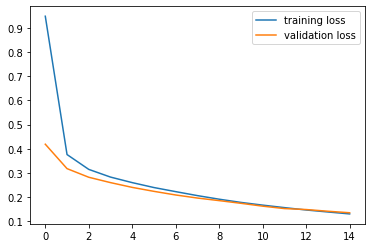

In [14]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
# 학습과 평가에 대한 오답률 그래프이다. 반복을 진행할수록 점점 오답률이 낮아지는 것을 알 수 있다.

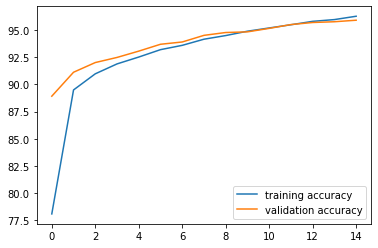

In [15]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
# 학습과 평가에 대한 정답률 그래프이다. 반복을 진행할수록 점점 정답률이 높아지는 것을 알 수 있다.

In [30]:
!pip3 install pillow==4.0.0

Requirement already up-to-date: pillow in /usr/local/lib/python3.6/dist-packages (8.1.0)


In [31]:
import PIL.ImageOps

In [34]:
# 제 로컬 환경에서는 AttributeError가 뜨면서 실행이 안되어서 조교님이 처음에 올려주신 ipynb 파일의 출력 결과를 보고 작성하였습니다!
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img) # 이미지를 배열 형태로 출력

AttributeError: ignored

In [26]:
img = PIL.ImageOps.invert(img)
img = img.convert('1') # 이미지를 단색화(흑백) 한다.
img = transform(img) # 이미지를 tensor로 변환
plt.imshow(im_convert(img)) # 흑백 도트 이미지 출력

NameError: ignored

In [27]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(pred.item()) # 이미지를 model에 넣어서 올바른 정답이 나오는지 확인한다. 출력 결과는 5였고, 잘 작동되는 것을 확인할 수 있었다.

NameError: ignored

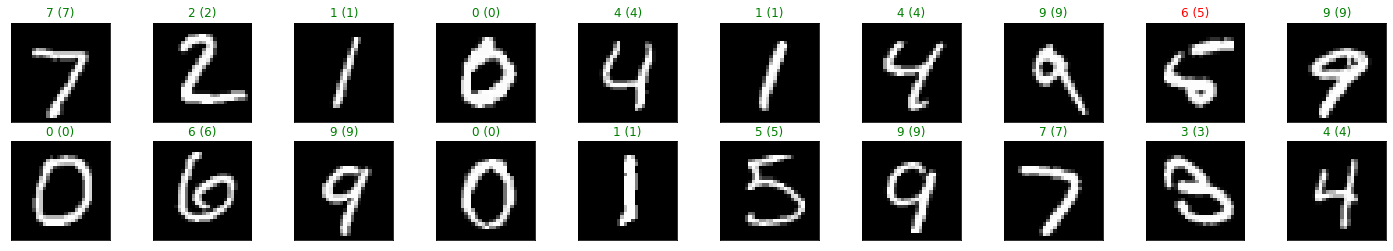

In [35]:
dataiter = iter(validation_loader) # iterator 선언
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1) # 이미지 행렬 모양 변환
output = model(images_) # 모델에 넣어서 평가
_, preds = torch.max(output, 1) # 0 ~ 9 중 무슨 값이 가장 정답에 가까운지(값이 큰지) 파악

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))
  # 예측값과 라벨이 같으면 정답, 다르면 오답이라고 시각적으로 보여준다.
  # 정답은 초록색 글씨로, 오답은 빨간색 글씨로 출력하며, 한 개의 오답을 제외하곤 모두 맞게 예측한 것을 알 수 있다.